## 1.1. EEG BASICS 
**Purpose**: Load EGG data, inspect metadata, plot raw signals, compute Power Spectral Density (PSD) using MNE-Python. 



In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mne.datasets import eegbci

# Setup plotting backend for interactive plots
%matplotlib inline
mne.set_config('MNE_DISPLAY_BACKEND', 'matplotlib', set_env=True)

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_9253/1120487020.py:10: RuntimeWarning: Setting non-standard config type: "MNE_DISPLAY_BACKEND"
  mne.set_config('MNE_DISPLAY_BACKEND', 'matplotlib', set_env=True)


### 1. Downloading the Dataset

We use MNE-Python's built-in `eegbci` module to fetch data from the PhysioNet EEG Motor Movement/Imagery dataset.
This dataset contains 64-channel EEG recordings sampled at 160 Hz.

The MNE-Python’s EEGBCI (EEG Brain-Computer Interface) dataset is part of the PhysioNet EEG Motor Movement/Imagery dataset.
- Designed for brain-computer interface (BCI) research.
- Includes EEG recordings of motor movements and motor imagery tasks.
- seful for testing EEG preprocessing, feature extraction, frequency analysis, and machine learning decoding.

Each “run” in the dataset corresponds to a specific task:
- Run 1–2: Baseline (eyes open / eyes closed)
- Run 3–6: Actual movement or motor imagery:
  - Opening and closing the left fist
  - Opening and closing the right fist
  - Both fists
  - Both feet

Each file contains:
- Continuous EEG signals from 64 electrodes (standard 10-20 layout is optional)
- Sampling frequency: usually 160 Hz
- Channel types: EEG, EOG (eye), EMG (if recorded)
- Metadata: recording time, channel names, measurement info

[https://physionet.org/content/eegmmidb/1.0.0/]

In [2]:
repo_root = Path("./").resolve().parents[1]
target_dir = repo_root / "datasets" / "eeg_sample"
target_dir.mkdir(parents=True, exist_ok=True)

print(f"Checking for data in: {target_dir}")

Checking for data in: /Users/yibeisita/Documents/neuro-ai-playground/datasets/eeg_sample


In [3]:
# Download Subject 1, Run 1 (Baseline, eyes open)
subject = 1
runs = [1]
file_paths = eegbci.load_data(subject, runs, path=str(target_dir))

In [4]:
# The path returned by MNE is often nested; we select the first file
eeg_file = Path(file_paths[0])
print(f"File ready: {eeg_file}")

File ready: /Users/yibeisita/Documents/neuro-ai-playground/datasets/eeg_sample/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf


### 2. Loading Data

The EEG data is stored in `.edf` (European Data Format). We load it into an MNE Raw object, which is the standard container for continuous data.

The Raw object contains:
- Continuous voltage signals for each EEG channel over time
- Sampling frequency (Hz)
- Channel names and types
- Timing and metadata

In [5]:
raw = mne.io.read_raw_edf(eeg_file, preload=True)

# Clean up channel names (removing the dots from names like 'Fcz.')
raw.rename_channels(lambda x: x.strip('.'))

print("\n--- Metadata Summary ---")
print(f"Sampling Rate: {raw.info['sfreq']} Hz")
print(f"Channels: {raw.ch_names[:5]} ... total {len(raw.ch_names)}")

Extracting EDF parameters from /Users/yibeisita/Documents/neuro-ai-playground/datasets/eeg_sample/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...

--- Metadata Summary ---
Sampling Rate: 160.0 Hz
Channels: ['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2'] ... total 64


### 3. Metadata and Electrode Placement Inspect Info
The metadata (stored in `raw.info`) contains technical details about the recording. In EEG, knowing the 10-20 system layout is crucial for interpreting which brain regions the electrodes are measuring, as it is a standardized method for naming and positioning electrodes based on proportional distances between anatomical landmarks on the scalp (e.g., nasion, inion, and preauricular points), ensuring consistent spatial correspondence across subjects and studies.

<img src="../../docs/eeg-electrode-placement.jpeg" width="500">

In [6]:
print("\n--- Info Metadata---")
print(raw.info)


--- Info Metadata---
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


### 4. Visualizing the Signal (Time Domain)

We plot the raw voltage fluctuations. This allows us to spot artifacts (like eye blinks or movement) and see the baseline brain activity. The plot shows the voltage over time for each EEG channel, each channel corresponds to one electrode.

Key points to observe:
- Spontaneous EEG oscillations (alpha, beta rhythms)
- Artifacts such as eye blinks or muscle activity
- Differences in amplitude and signal quality across channels

Using matplotlib as 2D backend.


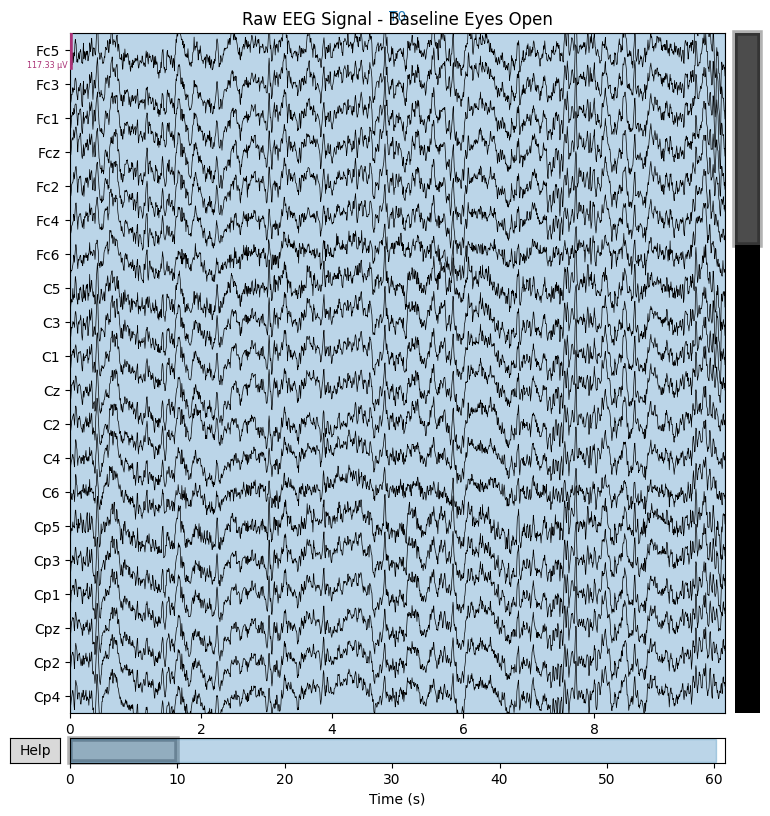

In [7]:
# Plot 10 seconds of data for 20 channels
fig = raw.plot(
    n_channels=20, 
    duration=10.0, 
    scalings='auto', 
    show=False
)

ax = fig.axes[0] 
ax.set_title("Raw EEG Signal - Baseline Eyes Open")

plt.show()

### 5. Frequency Analysis (Plot Power Spectral Density)
Transforming the signal from the Time Domain to the Frequency Domain helps us see the "rhythms" of the brain (Delta, Theta, Alpha, Beta). The Power Spectral Density (PSD) shows the signal power across frequency bands.

EEG frequency bands commonly observed:
- Delta: 0.5–4 Hz
- Theta: 4–8 Hz
- Alpha: 8–13 Hz
- Beta: 13–30 Hz
- Gamma: 30–100 Hz

This plot helps identify which frequency bands dominate in your EEG recording.

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_9253/3131741790.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot(picks="data",
/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


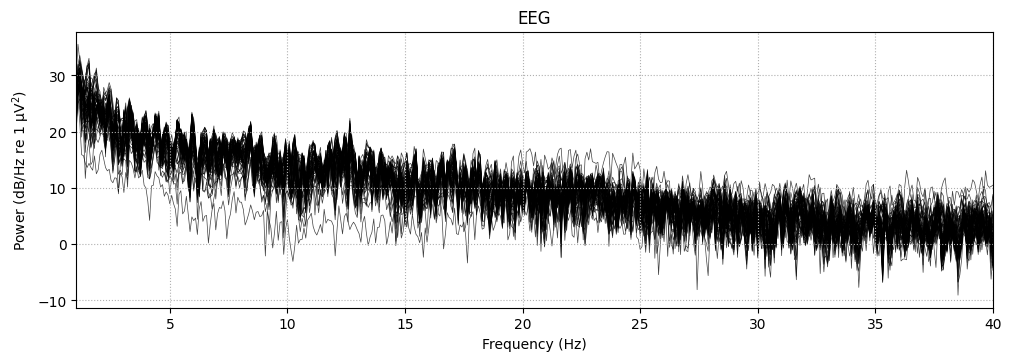

In [8]:
# Compute and plot PSD between 1Hz and 40Hz
psd = raw.compute_psd(fmin=1, fmax=40)

psd.plot(picks="data", 
         exclude="bads", 
         spatial_colors=True)

plt.show()